# Generate list of files to rescue
Data Rescue Boulder, for the NASA Moon Mission Records Rescue

Given: a list of assignments for the Data Rescue Boulder team in
`data/NASA_Project_Assignments.csv`

Goal: retrieve a recursive directory listing of all the files in those assignments, and produce a convenient csv file, `data/assigned_files.csv`, indicating for each file its length in bytes and which assignment it is part of.

Bonus: show some statistics on how many files there are per assignment, histogram of file sizes, etc.

Implemented in Python 3

In [1]:
import sys
import time
import os
import json
import re
import string
import collections
import itertools
import math
import glob
import random
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Copy of NASA_Project_Assignments.xlsx, saved as csv
project_assignments = pd.read_csv('../data/NASA_Project_Assignments.csv', keep_default_na=False)

In [4]:
project_assignments

,NSSDC ID,Priority (6 is high),Data directory location of scanned files,Addl info,"NASA or Goddard Reference , Reading, or other information links",Sandbox Location,Data File Conversion Info,Data Converted Files Location,"Data Schema File, notes, etc",Data Skeleton,PDF Conversion / Transcribed - note if Not Needed,CDF,NASA Data Defender Claimed By,NOTES,Column1,Status,Questions - pls date and add your inits,Answers,Column2
0,SPIO-00061,6,http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...,"NMC-Y, DSC-Y",,\DataDefender\NASA\plasma-frequency_electron-t...,@tracy ASCII...,"in each subfolder is a folder ""ConvertedFiles""",JS: uploaded DR002129_f000001.phys.PairedNorm...,,https://docs.google.com/document/d/1GioN-8mch3...,,@breqm76,,"In the orig PDF, at the end of FORMAT C, is t...",,04/27/2017 - JS,,
1,SPIO-00263,6,http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...,"NMC-Y, DSC-Y",,\DataDefender\NASA\signal_strength,,,,,https://docs.google.com/document/d/1xisJ2gjbL2...,,,,,,,,
2,SPIO-00048,6,http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...,"NMC-Y, DSC-Y",,,,,,,https://docs.google.com/document/d/1q2_Z_4y-yv...,,,,,,,,
3,SPMS-00544,6,http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/bi...,"NMC-Y, DSC-Y",,,,,,,,,,,,,,,
4,SPMS-00050,6,http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/el...,"NMC-Y, DSC-Y",,,,,,,,,,,,,,,
5,SPMS-00497,6,http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/om...,"NMC-Y, DSC-Y",,,,,,,,,,,,,,,
6,SPMS-00026,6,http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/om...,"NMC-Y, DSC-Y",,,,,,,,,,,,,,,
7,SPMS-00211,6,http://spdf.gsfc.nasa.gov/pub/data/ats/ats5/tr...,"NMC-Y, DSC-Y",,,,,,,,,,,,,,,
8,SPMS-00357,6,http://spdf.gsfc.nasa.gov/pub/data/azur/proton...,"NMC-Y, DSC-Y",,,,,,,,,,,,,,,
9,SPMS-00279,6,http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...,"NMC-Y, DSC-N",,,,,,,,,,,,,,,


In [5]:
len(project_assignments)

140

# Manual step to run lftp

Given the ftp directory name for each of the assignments, use this bash command to get the data.

I did this by hand the first time.  To really automate it, there is a small
step still unimplemented in this notebook: pull out the "Data directory location of scanned files" column above, for each of the "priority 6" assignments, save it in `assignment_urls.txt`.  Then run the bash command.
Or just feed it directly to an lftp command in a subprocess.

```
%%bash
for a in $(cat assignment_urls.txt); do
      ad=${a#http://spdf.gsfc.nasa.gov/pub/data/};
      lftp -c "open spdf.gsfc.nasa.gov; cd pub/data; find -l $ad > ${ad//\//|+}" ;
done
```

# Convert lftp output into csv

Read in the output of the lftp `find` commands from above, parse it, map it back to the assignment ids from the first csv file, and save in `data/assigned_files.csv`

In [6]:
FileInfo = collections.namedtuple('FileInfo', 'path assignment length')

def is_datafile(pathname):
    return not any([ext in pathname for ext in ['.pdf', '.html', '.tar', '.xml', '.txt', '.TAR', 'SHA1SUM']])

def allfiles():
    for assignment_ls_fn in glob.glob('../data/ls/*'):
        for result in read_lftp_ls(assignment_ls_fn):
            yield result

def read_lftp_ls(fn):
    """Return tuples of (filename, assignment) for all data files in given lftp listing, e.g.:
    drwxrwxr-x  leckner/spdf        6 2014-09-15 06:00:00 vela/vela-3a/example/
    -rwxr-xr--  leckner/spdf   193414 2008-08-26 06:00:00 vela/vela-3a/example/dr004366_f00001.phys.1
    """

    with open(fn, 'r') as f:
        for line in f.readlines():
            (perms, owners, length, date, time, *filename_maybe_symlinks) = line.split()
            # Ignore directories and symlinks like lrwxrwxrwx  leckner/kovalick   76 2014-09-09 06:00:00 symlink -> realfile
            if perms[0] != 'd' and len(filename_maybe_symlinks) == 1:
                filename = filename_maybe_symlinks[0]
                if is_datafile(filename):
                    assignment = get_assignment(filename)
                    yield FileInfo(filename, int(assignment), int(length))

In [7]:
def get_assignment(path):
    "Look given path up in list of assignments, and return index, or -1"
    for i, assignment_path in enumerate(project_assignments['Data directory location of scanned files']):
        assignment_path = assignment_path.strip()
        if path.startswith(assignment_path[35:] + '/'):
            return i
    return -1

In [8]:
# For example, this file is part of assignment 1
get_assignment('ariel/ariel3/vlf-receiver_fixed-frequency/signal_strength/DATA2_DR002106_DR002106_20080804_071839/dr002106_f00001.phys.1')

1

In [9]:
af = pd.DataFrame(allfiles())

In [10]:
af.index.names = ['id']

In [12]:
af.to_csv('../data/assigned_files.csv')

# Explore assigned_files.csv
<a id='assigned_files'></a> 

In [11]:
af

,path,assignment,length
id,,,
0,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3270980
1,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3270980
2,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3271308
3,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3270652
4,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3270816
5,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3270980
6,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3258468
7,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3478466
8,ariel/ariel3/langmuir_probe/plasma-frequency_e...,0,3249924


In [13]:
# Count of all files in all priority-6 assignments
len(af)

89332

In [14]:
# Statistics on file length in bytes
af.length.describe()

count    8.933200e+04
mean     8.812555e+05
std      4.115927e+06
min      8.000000e+00
25%      4.090000e+04
50%      1.363560e+05
75%      2.609740e+05
max      1.622941e+08
Name: length, dtype: float64

In [21]:
# Total size in GB
af.length.sum() / 1e9

78.724313491000004

In [30]:
range(0, af.length.max(), 100000)

range(0, 162294084, 100000)

<IPython.core.display.Javascript object>


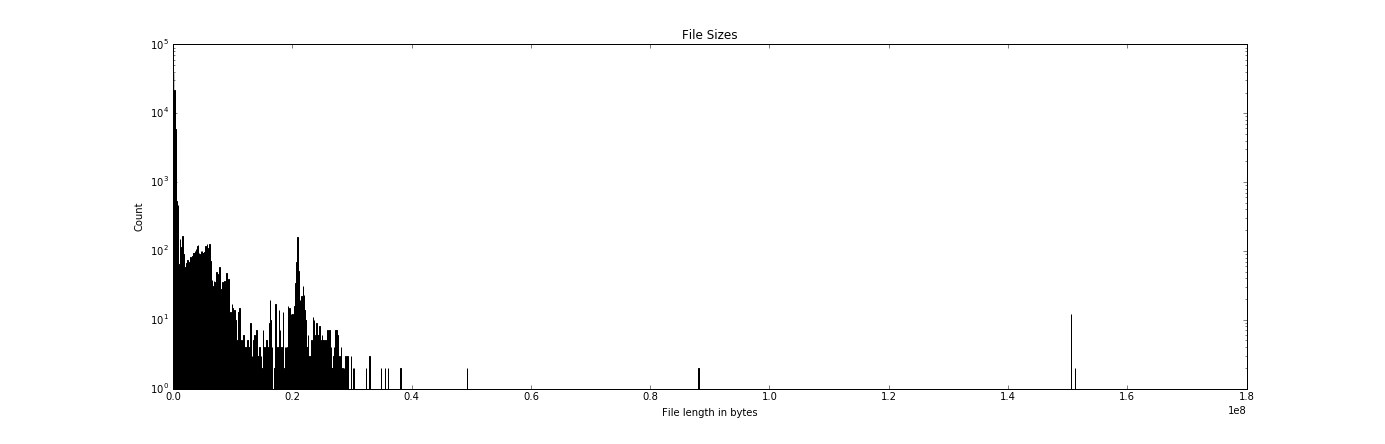

In [34]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set(title='File Sizes', xlabel='File length in bytes', ylabel='Count')
ax.hist(af.length, bins=range(0, af.length.max(), 100000))
ax.set_yscale('log')

In [16]:
# A few of the biggest ones
af.sort_values(by=['length'], ascending=False).head()

,path,assignment,length
id,,,
28610,imp/imp4/triaxial_fluxgate_magnetometer/2_dot_...,30,162294084
28592,imp/imp4/triaxial_fluxgate_magnetometer/2_dot_...,30,161961246
28601,imp/imp4/triaxial_fluxgate_magnetometer/2_dot_...,30,154129576
28673,imp/imp4/triaxial_fluxgate_magnetometer/2_dot_...,30,152779720
28664,imp/imp4/triaxial_fluxgate_magnetometer/2_dot_...,30,151435504


In [17]:
filecounts = pd.Series(collections.Counter([t[1] for t in allfiles()]), name='datafiles')

In [18]:
# Total number of files for each assignment
print(filecounts.to_string())

0        48
1        20
2     18116
3        20
4         1
5       246
6        10
7      8247
8         3
9        16
10        2
11       16
12        6
13      137
14      124
15        1
16      560
17        6
18        1
19      113
20        7
21        1
22      207
23      361
24       48
25        6
26      130
27        5
28      120
29        5
30      265
31        4
32        6
33      154
34       49
35       12
36      374
37      374
38      967
39       23
40      206
41      262
42       13
43      488
44        4
45       24
46       44
47       32
48       11
49      464
50        4
51        1
52      161
53     2114
54      629
55        4
56       29
57       66
58       95
59       47
60        5
61     1780
62     1092
63       17
64       21
65       13
66      305
67      288
68      254
69      215
70     7884
71     6523
72        1
73       18
74      120
75      166
76      246
77        1
78       58
79     5104
80    22507
81       66
82     3879
83  